In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, AggOperations, FilterTypes, WindowOperations, NoiseTypes

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split

from tsai.models.MINIROCKET import MiniRocketClassifier

import torch

In [2]:
from bci_dataset import BCIDataset

train_dataset = BCIDataset('data/train')[:]
inputs = train_dataset['inputs'].cpu().numpy()
# inputs = inputs.flatten(1, 2)
# inputs = inputs.mean(axis=1)
targets = train_dataset['targets']
targets = torch.argmax(targets, dim=1).cpu().numpy()

test_dataset = BCIDataset('data/test')[:]
inputs_test = test_dataset['inputs'].cpu().numpy()
# inputs_test = inputs_test.flatten(1, 2)
# inputs_test = inputs_test.mean(axis=1)
targets_test = test_dataset['targets']
targets_test = torch.argmax(targets_test, dim=1).cpu().numpy()

/home/stelath/GitHub/neuro-nav/bci_dataset.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  inp[k] = DataFilter.perform_fft(channel[: hz // 2], WindowOperations.NO_WINDOW.value)[:hz // 4]


In [8]:
inputs_train, inputs_valid, targets_train, targets_valid = train_test_split(inputs, targets, test_size=0.3, random_state=42)
# inputs_test, targets_test = format_dataset(test_dataset)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

model = MiniRocketClassifier()
model = model.fit(inputs_train, targets_train)

# grid_cv = GridSearchCV(model, param_grid, n_jobs=-1).fit(inputs_train, targets_train)
# model = grid_cv

In [9]:
plt.style.use('seaborn-v0_8-white')

Validation Accuracy: 0.437984496124031
Test Accuracy: 0.4011627906976744


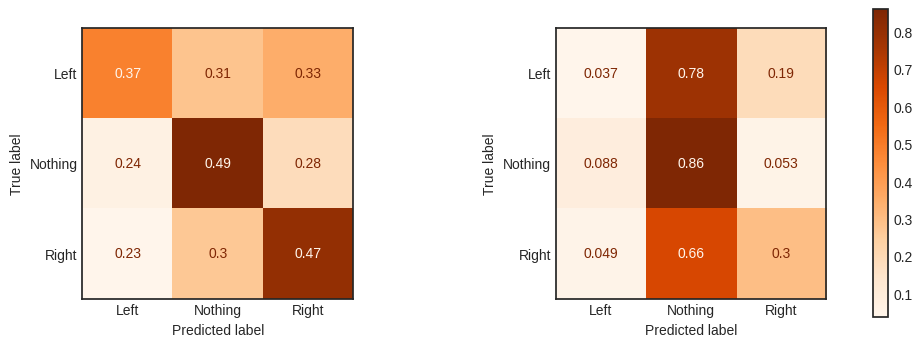

In [10]:
pred_valid = model.predict(inputs_valid)
pred_test = model.predict(inputs_test)

vaccuracy = metrics.accuracy_score(targets_valid, pred_valid)
print(f"Validation Accuracy: {vaccuracy}")

taccuracy = metrics.accuracy_score(targets_test, pred_test)
print(f"Test Accuracy: {taccuracy}")



f, axes = plt.subplots(1, 2)

vcm = metrics.confusion_matrix(targets_valid, pred_valid, normalize='true')
vdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=vcm, display_labels=['Left', 'Nothing', 'Right'])
vdisp.plot(ax=axes[0], cmap=plt.cm.Oranges)
vdisp.im_.colorbar.remove()

plt.subplot(1, 2, 2)
tcm = metrics.confusion_matrix(targets_test, pred_test, normalize='true')
tdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=tcm, display_labels=['Left', 'Nothing', 'Right'])
tdisp.plot(ax=axes[1], cmap=plt.cm.Oranges)
tdisp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.75, hspace=0.1)
f.colorbar(tdisp.im_, ax=axes, shrink=0.5)
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.show()

In [9]:
model.save('MiniRocketModel')

AttributeError: 'MiniRocketClassifier' object has no attribute 'tree_'

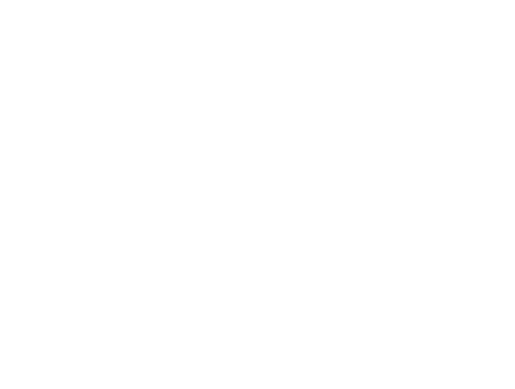

In [6]:
plot_tree(model)

In [ ]:
board.stop_stream()

In [ ]:
board.start_stream()
BoardShim.disable_board_logger()

sample_size = 512
start_time = time.time()
last_read = start_time
time.sleep(3)

realtime_raw_data = board.get_board_data()[1:9]

while start_time + 30 > time.time():
    realtime_raw_data = np.concatenate((realtime_raw_data, board.get_board_data()[1:9]), axis=1)[:,-sample_size:]
    
    realtime_data = np.mean(realtime_raw_data, axis=0)
    
    sr = 256
    
    delta = downsample(realtime_data, 2)[-1]
    theta = downsample(realtime_data, 5)[-1]
    alpha_low = downsample(realtime_data, 8)[-1]
    alpha_high = downsample(realtime_data, 11)[-1]
    beta_low = downsample(realtime_data, 15)[-1]
    beta_high = downsample(realtime_data, 24)[-1]
    gamma_low = downsample(realtime_data, 35)[-1]
    gamma_mid = downsample(realtime_data, 45)[-1]
    gamma_high = downsample(realtime_data, 55)[-1]
    
    
    if time.time() > last_read + 0.5:
        predictions = model.predict(np.array([delta, theta, alpha_low, alpha_high, beta_low, beta_high, gamma_low, gamma_mid, gamma_high]).reshape(1, -1))
        last_read = time.time()
        print(['Left', 'Nothing', 'Right'][predictions[0]])
    
    time.sleep(0.1)

board.stop_stream()

In [4]:
board.release_session()